<a href="https://colab.research.google.com/github/Eieiz007/Machine-learning/blob/main/Segmentation_unsupervied_DBSCAN_KMEAN_HIERARCHY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans ,DBSCAN , HDBSCAN , AgglomerativeClustering , OPTICS
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid


In [ ]:
df = pd.read_csv("Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
df = df.drop(columns=['CustomerID','Gender',"Age"])
df

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
...,...,...
195,120,79
196,126,28
197,126,74
198,137,18


Text(0, 0.5, 'Score')

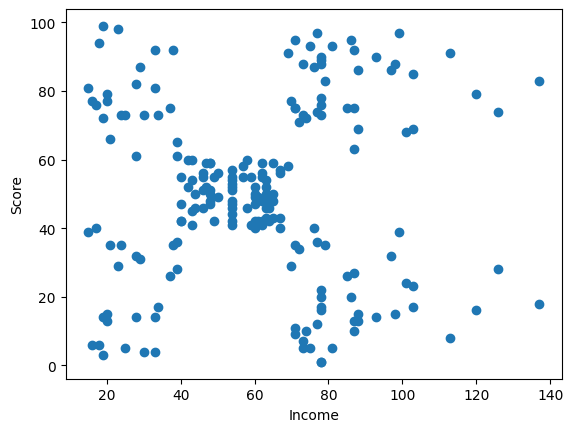

In [ ]:
plt.scatter(df['Annual Income (k$)'] , df['Spending Score (1-100)'])
plt.xlabel("Income")
plt.ylabel("Score")

In [ ]:
df.columns

Index(['Annual Income (k$)', 'Spending Score (1-100)'], dtype='object')

In [ ]:
df.describe()

,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000
mean,60.560000,50.200000
std,26.264721,25.823522
min,15.000000,1.000000
25%,41.500000,34.750000
50%,61.500000,50.000000
75%,78.000000,73.000000
max,137.000000,99.000000


In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(df)  # นำข้อมูลมาทำ Standardization
X = pd.DataFrame(X, columns=['income', 'score'])
X

,income,score
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980
...,...,...
195,2.268791,1.118061
196,2.497807,-0.861839
197,2.497807,0.923953
198,2.917671,-1.250054


Text(0, 0.5, 'Score')

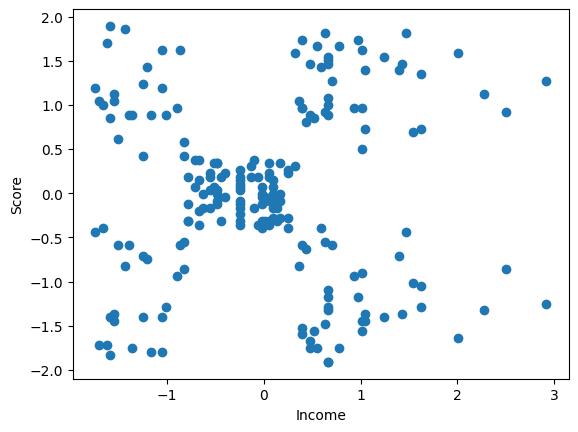

In [ ]:
plt.scatter(X['income'] , X['score'])
plt.xlabel("Income")
plt.ylabel("Score")

# Kmean

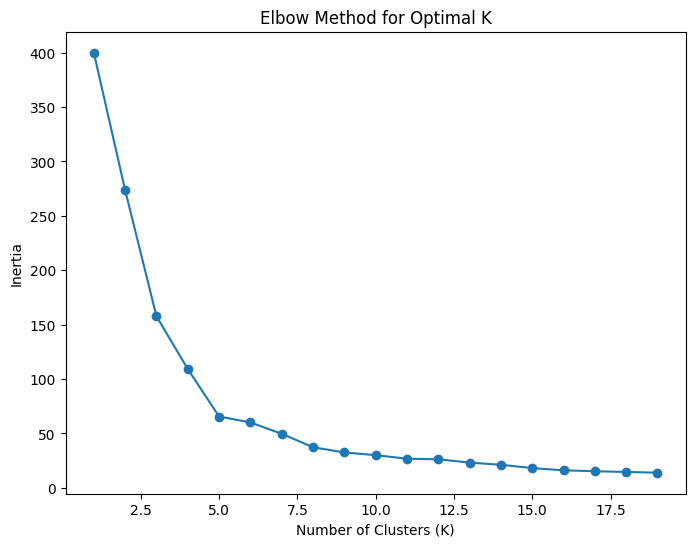

In [ ]:
# ขั้นตอนที่ 2: หาจำนวน K ที่เหมาะสมโดยใช้ Elbow Method
inertia = []  # ใช้เก็บค่าของ Inertia (Sum of squared distances)

# ทดสอบจำนวน K (จาก 1 ถึง 10)
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# แสดงกราฟ Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

In [ ]:
for k in range(2, 11):  # K ต้องเริ่มจาก 2 ขึ้นไป
    kmean_test = KMeans(n_clusters=k, random_state=32)
    labels_test = kmean_test.fit_predict(X)

    # คำนวณ Silhouette Score
    score = silhouette_score(X, labels_test)
    print(f"k={k}",score)


k=2 0.3949494377743765
k=3 0.46658474419000145
k=4 0.49434988482196784
k=5 0.5539423799434205
k=6 0.45554877702282853
k=7 0.4523909078942399
k=8 0.4604200199746406
k=9 0.4607676809309511
k=10 0.4507937437744966


In [ ]:
k_optimal = 5  # จากการดูกราฟ Elbow Method

kmeans_train = KMeans(n_clusters=k_optimal, random_state=35)
labels_kmean = kmeans_train.fit_predict(X)

score_kmean = silhouette_score(X, labels_kmean)
print(score_kmean)

0.5546571631111091


In [ ]:
# เพิ่มผลลัพธ์ลงใน DataFrame
df = pd.DataFrame(X, columns=['income', 'score'])
df['kmean'] = labels_kmean

<Axes: xlabel='income', ylabel='score'>

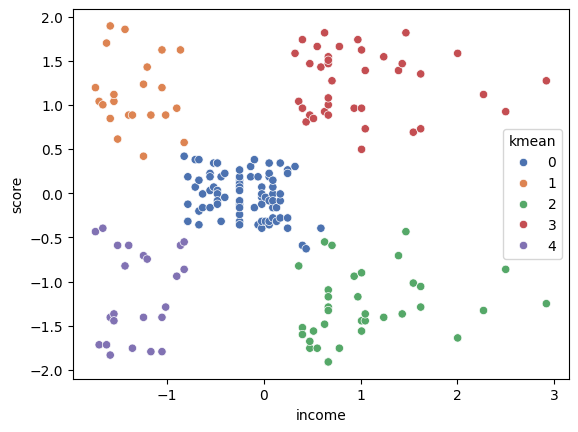

In [ ]:
sns.scatterplot(data=df,x='income',y='score',hue='kmean',palette="deep")

# DBSCAN

In [ ]:
param_grid = {
    'eps': [0.01,0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
    'min_samples': [1,2,3, 4, 5, 6, 7, 8],
    'metric': ['euclidean', 'manhattan', ],  # เพิ่ม metric
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # เพิ่ม algorithm
}

# ขั้นตอนที่ 3: ใช้ Grid Search เพื่อหาค่าที่ดีที่สุดของ eps และ min_samples
best_score = -1  # ใช้เก็บค่าของ Silhouette Score ที่ดีที่สุด
best_params = {}  # ใช้เก็บค่าพารามิเตอร์ที่ดีที่สุด

# ลองทุกๆ ค่าพารามิเตอร์จาก Grid Search
for params in ParameterGrid(param_grid):
    eps = params['eps']
    min_samples = params['min_samples']
    metric = params['metric']
    algorithm = params['algorithm']

    # สร้างโมเดล DBSCAN ด้วยพารามิเตอร์ปัจจุบัน
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric, algorithm=algorithm)
    labels = dbscan.fit_predict(X)

    # คำนวณ Silhouette Score
    if len(set(labels)) > 1:  # คำนวณได้เฉพาะถ้ามีมากกว่าหนึ่งคลัสเตอร์
        score = silhouette_score(X, labels)
        print(score)

        # อัปเดตค่าที่ดีที่สุด
        if score > best_score:
            best_score = score
            best_params = params

# แสดงผลลัพธ์
dbscan_score = best_score
print(f"Best Silhouette Score: {best_score:.4f}")
print(f"Best Parameters: {best_params}")

0.04
-0.5039775112770212
0.04
-0.5039775112770212
0.30034080305381233
0.0660876788435225
-0.20308391205535767
-0.27565539274724876
-0.2700934604293137
-0.301443775619125
-0.28431740706316444
0.22920259454566697
-0.06831030791138418
-0.2949599665450487
-0.27802445873283327
-0.3384406469680276
-0.2937708689049414
0.2303172836524675
0.20606104897946675
0.23058471130629898
0.19685111632552818
0.14057942679617558
0.09644483815713827
0.05559332249286136
0.04120506369450064
0.25142746846117886
0.17526330544334598
0.061267986865891653
0.07326181933502396
0.05027301384074743
0.023302722428704844
-0.020263940606578178
0.04897867830125807
0.3084209532989007
0.3745966900645067
0.4136187833583574
0.38427960728258165
0.31614121976731185
0.24983531622925184
0.23146493255355374
0.19432071085905328
0.30193903480731016
0.32045976304907187
0.2782925898891186
0.17163622665089093
0.17272770173830196
0.15485845148967173
0.12642363835665202
0.12415071236433463
0.28742025766331464
0.32219422583342383
0.362691

In [ ]:
# ขั้นตอนที่ 4: ใช้ค่าพารามิเตอร์ที่ดีที่สุดทำการ DBSCAN
best_dbscan = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
best_labels = best_dbscan.fit_predict(X)

# เพิ่มผลลัพธ์ลงใน DataFrame
df['DBSCAN'] = best_labels

<Axes: xlabel='income', ylabel='score'>

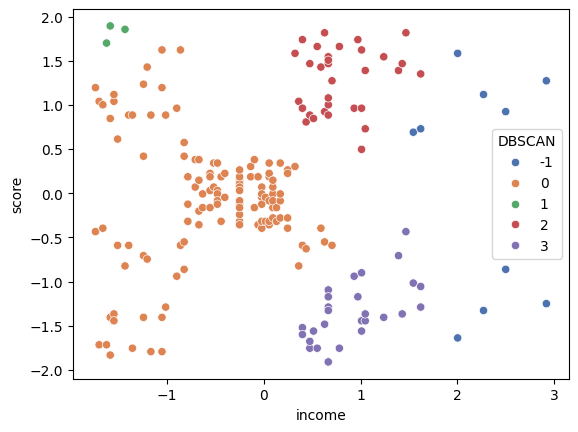

In [ ]:
sns.scatterplot(data=df,x='income',y='score',hue='DBSCAN',palette="deep")

# HIERARCHY

In [ ]:

# ขั้นตอนที่ 2: ตั้งค่าช่วงของพารามิเตอร์ที่ต้องการทำ Grid Search
param_grid = {
    'n_clusters': [2, 3, 4, 5, 6],  # จำนวนคลัสเตอร์ที่ต้องการ
    'linkage': ['ward', 'complete', 'average'],  # วิธีการเชื่อมคลัสเตอร์
}

# ขั้นตอนที่ 3: ใช้ Grid Search เพื่อหาค่าที่ดีที่สุดของ n_clusters, linkage, affinity
best_score = -1  # ใช้เก็บค่าของ Silhouette Score ที่ดีที่สุด
best_params = {}  # ใช้เก็บค่าพารามิเตอร์ที่ดีที่สุด

# ลองทุกๆ ค่าพารามิเตอร์จาก Grid Search
for params in ParameterGrid(param_grid):
    n_clusters = params['n_clusters']
    linkage = params['linkage']

    # สร้างโมเดล AgglomerativeClustering ด้วยพารามิเตอร์ปัจจุบัน
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    labels = agglomerative.fit_predict(X)

    # คำนวณ Silhouette Score
    if len(set(labels)) > 1:  # คำนวณได้เฉพาะถ้ามีมากกว่าหนึ่งคลัสเตอร์
        score = silhouette_score(X, labels)
        print(score)
        # อัปเดตค่าที่ดีที่สุด
        if score > best_score:
            best_score = score
            best_params = params

# แสดงผลลัพธ์
agglo_score = best_score
print(f"Best Silhouette Score: {best_score:.4f}")
print(f"Best Parameters: {best_params}")




0.3842337621772661
0.4610481446570447
0.4925507715349343
0.5538089226688662
0.5386761871036926
0.36071083057634323
0.46658474419000145
0.49588122834195303
0.5531118656926701
0.5440860136367434
0.3842337621772661
0.46658474419000145
0.49588122834195303
0.4794263081846086
0.46540298817361486
0.3842337621772661
0.4610481446570447
0.4925507715349343
0.5538089226688662
0.5386761871036926
0.36071083057634323
0.46658474419000145
0.49588122834195303
0.5531118656926701
0.5440860136367434
0.3842337621772661
0.46658474419000145
0.49588122834195303
0.4794263081846086
0.46540298817361486
Best Silhouette Score: 0.5538
Best Parameters: {'affinity': 'euclidean', 'linkage': 'ward', 'n_clusters': 5}


In [ ]:
# ขั้นตอนที่ 4: ใช้ค่าพารามิเตอร์ที่ดีที่สุดทำการ Agglomerative Clustering
best_agglomerative = AgglomerativeClustering(n_clusters=best_params['n_clusters'],
                                             linkage=best_params['linkage'], )
best_labels = best_agglomerative.fit_predict(X)

# เพิ่มผลลัพธ์ลงใน DataFrame
df['Agglo'] = best_labels

In [ ]:
df

,income,score,kmean,DBSCAN,Agglo
0,-1.738999,-0.434801,4,0,4
1,-1.738999,1.195704,1,0,3
2,-1.700830,-1.715913,4,0,4
3,-1.700830,1.040418,1,0,3
4,-1.662660,-0.395980,4,0,4
...,...,...,...,...,...
195,2.268791,1.118061,3,-1,1
196,2.497807,-0.861839,2,-1,0
197,2.497807,0.923953,3,-1,1
198,2.917671,-1.250054,2,-1,0


# Compare model

In [ ]:
score_kmean , agglo_score , dbscan_score

(0.5546571631111091, 0.5538089226688662, 0.47020614501156915)

In [ ]:
df

,income,score,kmean,DBSCAN,Agglo
0,-1.738999,-0.434801,4,0,4
1,-1.738999,1.195704,1,0,3
2,-1.700830,-1.715913,4,0,4
3,-1.700830,1.040418,1,0,3
4,-1.662660,-0.395980,4,0,4
...,...,...,...,...,...
195,2.268791,1.118061,3,-1,1
196,2.497807,-0.861839,2,-1,0
197,2.497807,0.923953,3,-1,1
198,2.917671,-1.250054,2,-1,0


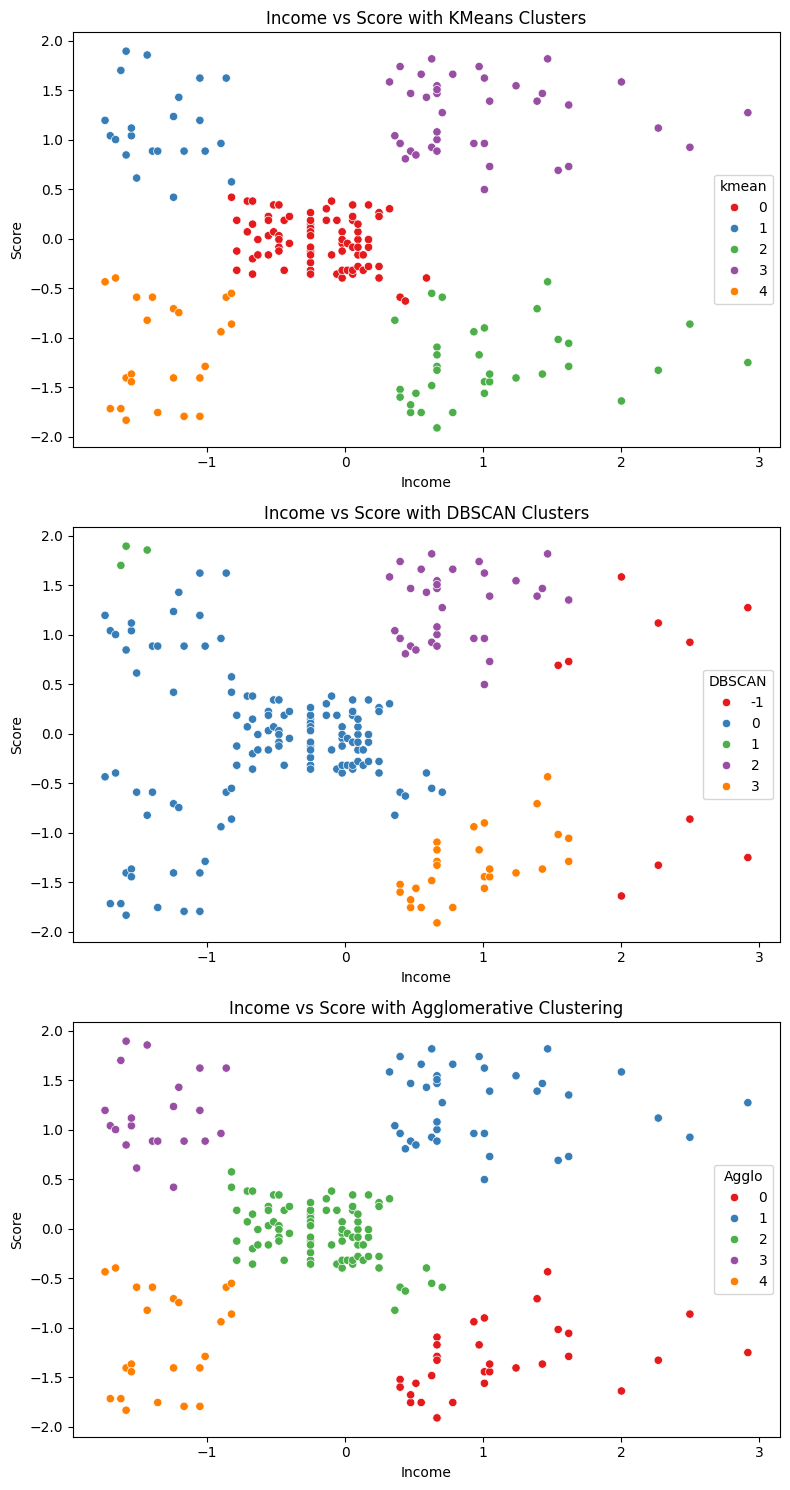

In [ ]:


# กำหนดขนาดกราฟ
plt.figure(figsize=(8, 15))

# สร้างกราฟ KMeans
plt.subplot(3, 1, 1)  # 3 แถว 1 คอลัมน์ กราฟแรก
sns.scatterplot(data=df, x='income', y='score', hue='kmean', palette='Set1', marker='o')
plt.title('Income vs Score with KMeans Clusters')
plt.xlabel('Income')
plt.ylabel('Score')

# สร้างกราฟ DBSCAN
plt.subplot(3, 1, 2)  # 3 แถว 1 คอลัมน์ กราฟที่สอง
sns.scatterplot(data=df, x='income', y='score', hue='DBSCAN', palette='Set1', marker='o')
plt.title('Income vs Score with DBSCAN Clusters')
plt.xlabel('Income')
plt.ylabel('Score')

# สร้างกราฟ Agglomerative
plt.subplot(3, 1, 3)  # 3 แถว 1 คอลัมน์ กราฟที่สาม
sns.scatterplot(data=df, x='income', y='score', hue='Agglo', palette='Set1', marker='o')
plt.title('Income vs Score with Agglomerative Clustering')
plt.xlabel('Income')
plt.ylabel('Score')

# ปรับการแสดงผล
plt.tight_layout()
plt.show()
